In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)

In [2]:
import pqr

# Загрузка и предобработка данных

In [3]:
# загружаем цены
prices = pd.read_excel('factors/russia/monthlyprice.xlsx', index_col=0, parse_dates=True)
# загружаем данные по рыночной капитализации
mcap = pd.read_excel('factors/russia/mcap.xlsx', index_col=0, parse_dates=True)
# загружаем данные по среднему объему торгов за день
volume = pd.read_excel('factors/russia/betafilter.xlsx', index_col=0, parse_dates=True)
# загружаем бенчмарк
imoex = pd.read_excel('factors/russia/imoex.xlsx', index_col=0, parse_dates=True)

In [4]:
prices = prices.replace(0, np.nan)
mcap = mcap.replace(0, np.nan)
volume = volume.replace(0, np.nan)
imoex = imoex.replace(0, np.nan)

# Переходим к факторам

In [5]:
# фильтрующий фактор преобразуем сразу с looking_period=1 во избежание look-ahead bias
liquidity_filter = pqr.Factor(volume).look_back() > 10_000_000

# основной фактор для отбора бумаг -- фактор размера
size = pqr.Factor(mcap).look_back(3).hold(3)
size.filter(liquidity_filter)

In [6]:
# у нас есть индекс-бенчмарк
benchmark = pqr.Benchmark('IMOEX').from_index(imoex['IMOEX'])

# 1 способ использования: строим факторную модель

Данный способ хорошо подходит для первичного анализа фактора и научных исследований наличия факторов на том или ином рынке.

Сначала построим одну модель с параметрами 3-0-3

In [7]:
# "обучаем" факторную модель
portfolios = pqr.fit_quantile_factor_model(
    stock_prices=prices,
    factor=size,
    add_wml=True, # добавим wml-портфель
    better='less',  # укажем, что чем ниже значения фактора, тем более привлекательна компания
    quantiles=3
)

In [8]:
pqr.mean_excess_return(portfolios[1].returns, benchmark.returns)

MeanExcessReturn(value=0.006964635575541583, t_stat=0.19263454085480544, p_value=0.42371841351186523)

,winners,p2,losers,wml
"Total Return, %",280.58,694.8,530.36,-32.41
"CAGR, %",8.14,12.9,11.38,-2.27
"Volatility, %",31.86,27.93,24.35,17.52
"Win Rate, %",55.12,58.05,60.0,46.83
"Maximum Drawdown, %",-82.07,-69.6,-68.97,-53.59
"VaR, %",-44.38,-34.95,-37.05,-26.14
"Expected Tail Loss, %",-67.21,-57.49,-56.65,-35.6
Rachev Ratio,1.1,1.22,0.89,1.13
Calmar Ratio,0.1,0.19,0.16,-0.04
Sharpe Ratio,0.41,0.58,0.57,-0.04


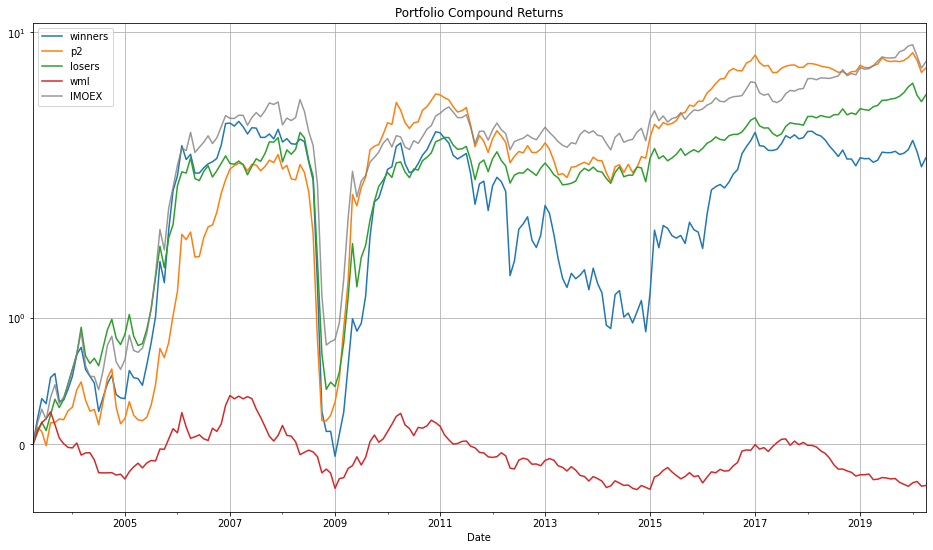

In [9]:
pqr.summary_tear_sheet(portfolios, benchmark)

## Поищем модель получше

Результаты получились не очень: ни один портфель не победил бенчмарк. Скорее всего, параметры подобраны неправильно, но вручную перебирать их может быть довольно-таки трудозатратно. К тому же, есть риск пропустить хорошую модель.

Поэтому воспользуемся перебором параметров.

In [10]:
import functools as ft

target_alpha = lambda r: pqr.alpha(r, benchmark.returns).value

params = [
    (1, 0, 1),
    (1, 1, 1),
    (3, 0, 3),
    (3, 1, 3),
    (6, 0, 6),
    (6, 1, 6),
    (12, 0, 12),
    (12, 1, 12),
]

results = pqr.grid_search(prices, mcap, params, target_alpha, mask=liquidity_filter, quantiles=3)

In [11]:
results

,winners,p2,losers
"(1, 0, 1)",-0.067661,0.045735,-0.008791
"(1, 1, 1)",-0.034433,0.035368,0.005428
"(3, 0, 3)",-0.036315,0.014118,-0.007249
"(3, 1, 3)",-0.036240,-0.002428,-0.000811
"(6, 0, 6)",-0.035289,0.011809,0.013186
"(6, 1, 6)",-0.044825,0.001356,0.005500
"(12, 0, 12)",-0.045663,0.022754,0.002110
"(12, 1, 12)",-0.049908,0.021419,0.000085


<AxesSubplot:>

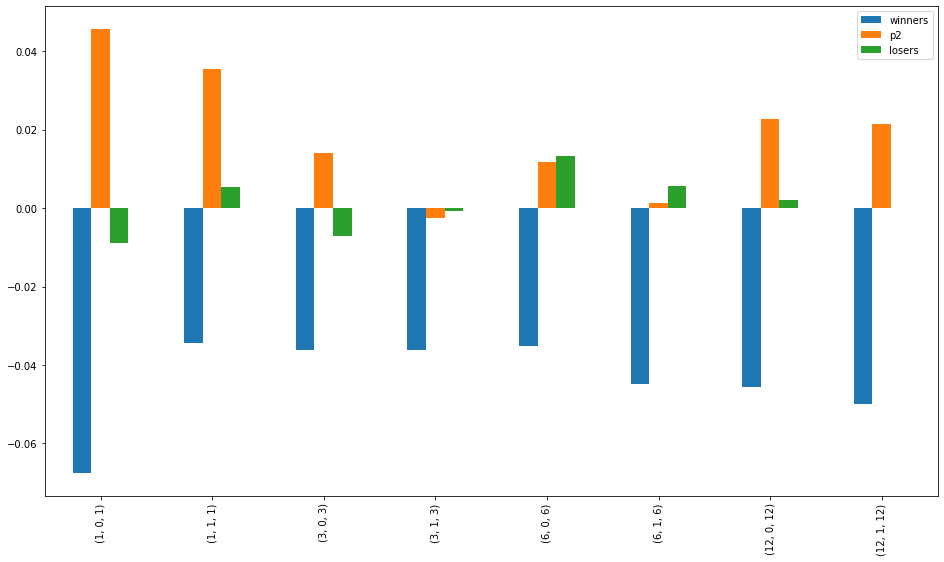

In [12]:
results.plot.bar()

In [13]:
portfolios = pqr.fit_quantile_factor_model(
    stock_prices=prices,
    factor=pqr.Factor(mcap).look_back().filter(liquidity_filter),
    add_wml=True,
    quantiles=3
)

In [14]:
pqr.mean_excess_return(portfolios[1].returns, benchmark.returns)

MeanExcessReturn(value=0.035191216328503166, t_stat=0.8791645024350581, p_value=0.19016822740371914)

,winners,p2,losers,wml
"Total Return, %",139.99,1209.61,554.15,-59.21
"CAGR, %",5.21,16.08,11.5,-5.07
"Volatility, %",32.59,28.44,24.69,18.34
"Win Rate, %",54.59,60.39,59.42,45.41
"Maximum Drawdown, %",-84.86,-72.82,-70.45,-70.23
"VaR, %",-47.84,-33.3,-33.92,-27.42
"Expected Tail Loss, %",-70.1,-57.97,-56.89,-38.02
Rachev Ratio,1.07,1.18,0.91,1.11
Calmar Ratio,0.06,0.22,0.16,-0.07
Sharpe Ratio,0.32,0.67,0.57,-0.19


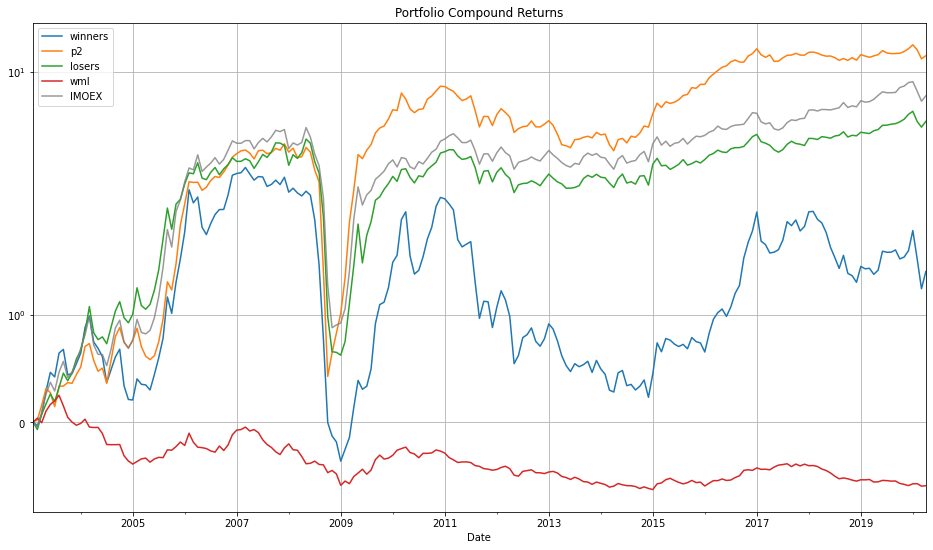

In [15]:
pqr.summary_tear_sheet(portfolios, benchmark)

### Лучший портфель поподробнее

Шарп получился меньше 1, не очень впечатляет, но посмотрим поподробнее на данный портфель. После обучения модели все портфели сохраняются в список, нас интересует 2 элемент.

In [16]:
best_portfolio = portfolios[1]

Посмотрим на изменение годовой беты портфеля: видно, что в основном бета колеблется около 1, но в последние годы снизилась почти на половину.

<AxesSubplot:xlabel='Date'>

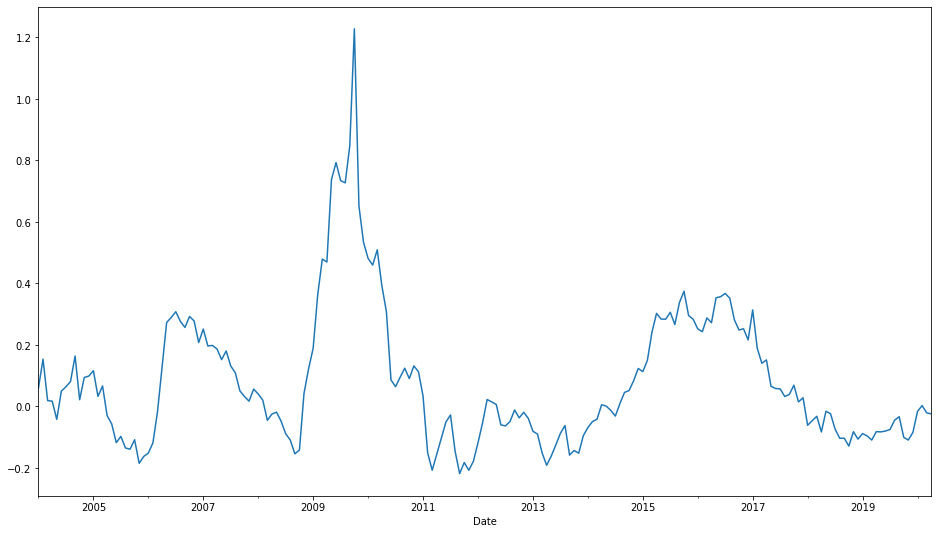

In [17]:
pqr.rolling_alpha(best_portfolio.returns, benchmark.returns).plot()

In [18]:
pqr.alpha(best_portfolio.returns, benchmark.returns)

Alpha(value=0.04573474666699294, t_stat=1.1268766018040952, p_value=0.2611119764974137)

Годовой Шарп выглядит совсем непривлекательно - американские горки.

<AxesSubplot:xlabel='Date'>

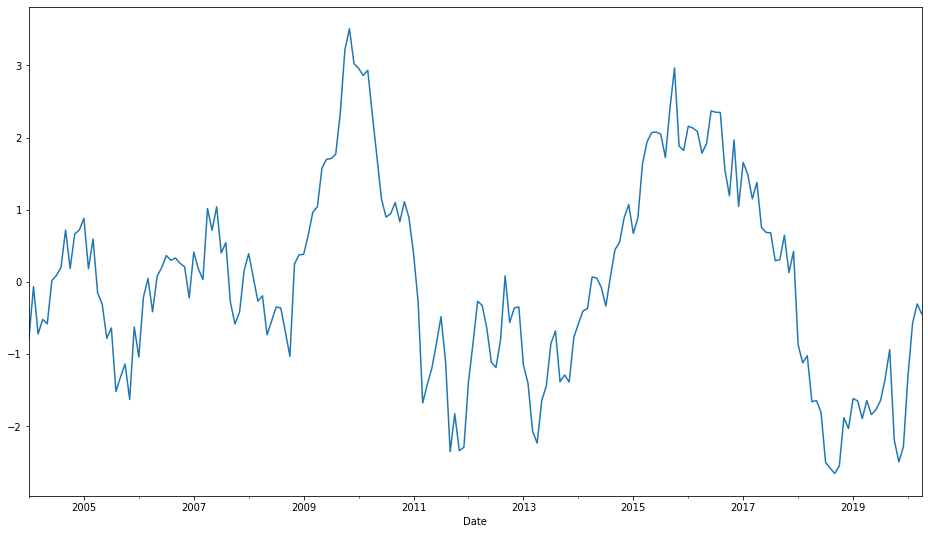

In [19]:
pqr.rolling_sharpe_ratio(best_portfolio.returns, benchmark.returns).plot()

Годовая просадка в целом не так ужасно выглядит, но в 2008 падение стоило бы всего портфеля, и даже чуть больше, поэтому окончательно отметаем данный портфель.

<AxesSubplot:xlabel='Date'>

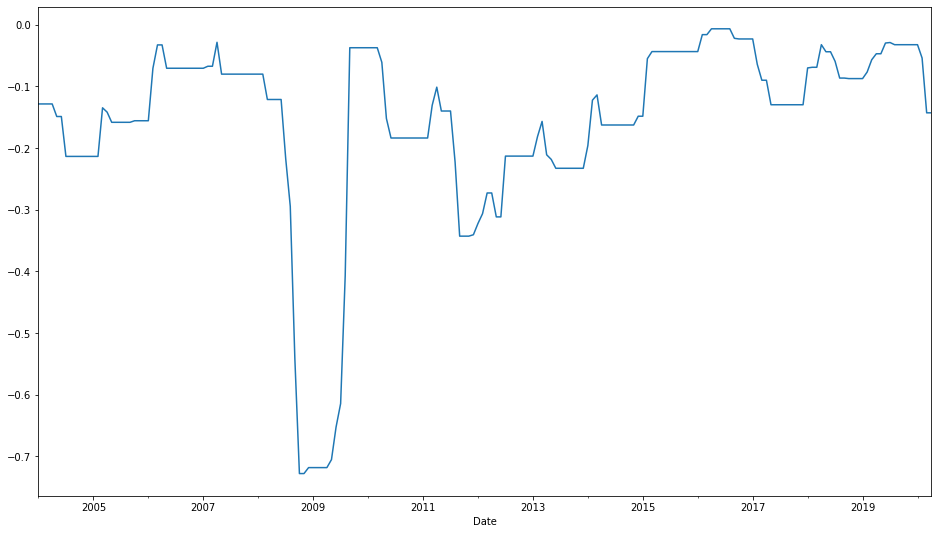

In [20]:
pqr.rolling_max_drawdown(best_portfolio.returns).plot()

# 2 способ использования: строим и настраиваем портфель

В примере выше мы хотели рассмотреть всего 1 портфель, для этого нам не было необходимости строить еще 2 дополнительных. Но данная глава нужна не только для того, чтобы облегчить расчеты, иногда нас может интересовать конкретный портфель, и мы хотим сконцентрироваться на его настройке. Ну или требуется более подробно изучить фактор.

Но для этого придется чуть больше погрузиться в библиотеку.

In [21]:
# создадим 2 портфеля

# портфель, включающий в себя топ-10 акций по значению фактора
# для фактора размера это в действительности топ-10 худших компаний, т.е. топ-10 с наиболее высокой капитализацией
top10_portfolio = pqr.Portfolio('top-10')

# портфель, включающий 10% бумаг с наименьшим значением фактора
q01_portfolio = pqr.Portfolio('q-0.1')

In [22]:
# проинвестируем в оба в стратегию 3-0-3
top10_portfolio.pick_by_factor(
    factor=size,
    thresholds=(1, 10),
    method='top'
).weigh_equally().allocate(prices)


q01_portfolio.pick_by_factor(
    factor=size,
    thresholds=(0, 0.1),
    method='quantile'
).weigh_equally().allocate(prices);

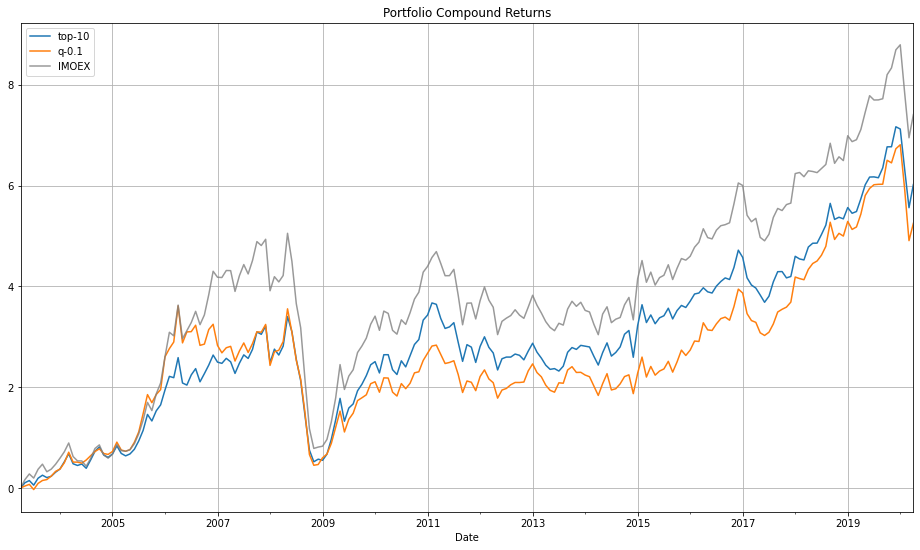

In [23]:
pqr.plot_compound_returns([top10_portfolio, q01_portfolio], benchmark)

Окей, возьмем в разработку портфель из топ-10 компаний по капитализации. Попробуем взвесить его по ней же, получится по сути своей смарт-бета портфель (за тем лишь исключением, что фактор размера мы используем в другую сторону:)).

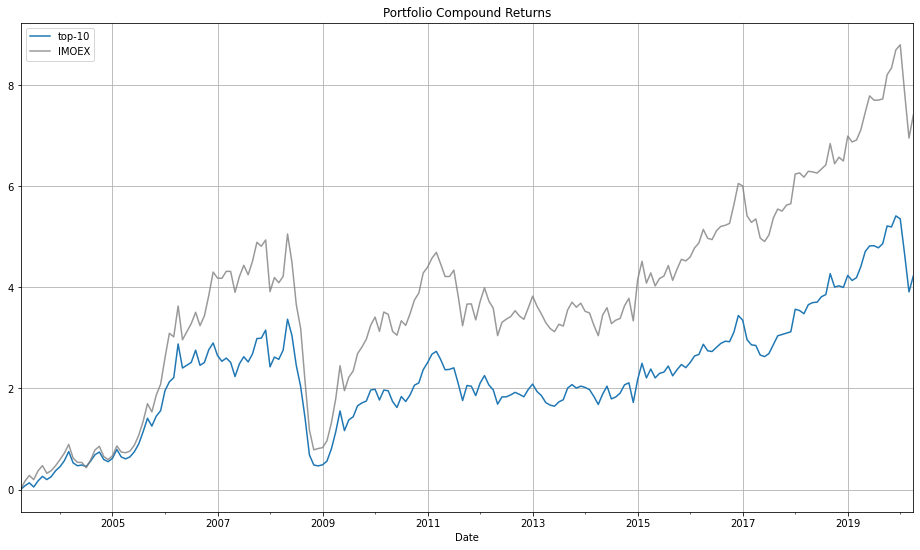

In [24]:
top10_portfolio.weigh_by_factor(size).allocate(prices)

pqr.plot_compound_returns([top10_portfolio], benchmark)

Как бы это не выглядело странным, но после перехода от равных весов к взвешиванию по капитализации, портфель довольно сильно отстал от бенчмарка. Попробуем, наоборот.

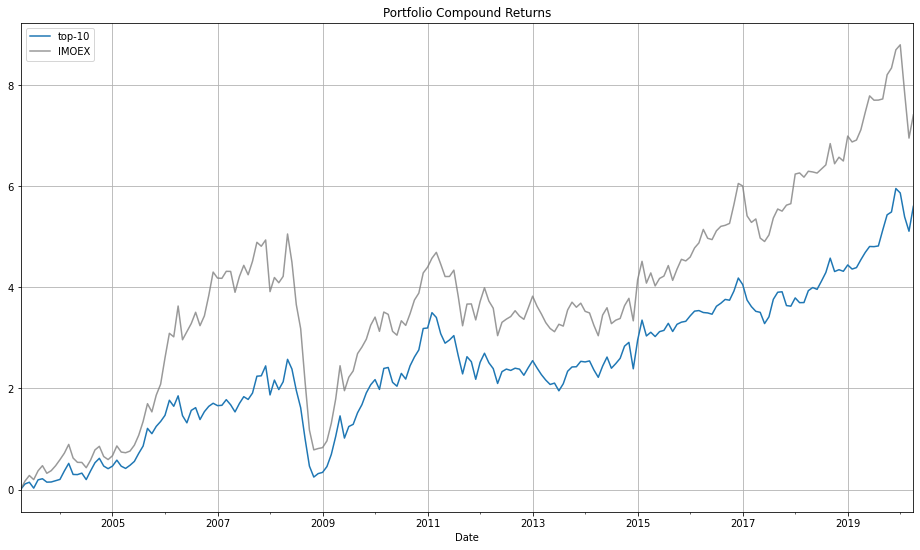

In [25]:
top10_portfolio.weigh_by_factor(
    pqr.Factor(1 / mcap).look_back()
).allocate(prices)

pqr.plot_compound_returns([top10_portfolio], benchmark)

Отставание от бенчмарка сократилось, но по-прежнему больше, чем при портфеле с равными весами. Обогнать бенчмарк на основе фактора размера на российском рынке не вышло, но это мы еще не пробовали другие параметры. Пока признаем поражение и посмотрим, что еще можно достать из портфеля.

## Немного аналитики по портфелю

Посмотрим, какие вообще компании в основном были в нашем портфеле. Абсолютными лидерами стали Сбербанк, Сургутнефтегаз, Норникель и Лукойл. Выглядит так, что они были в нашем портфеле вообще всегда.

<AxesSubplot:>

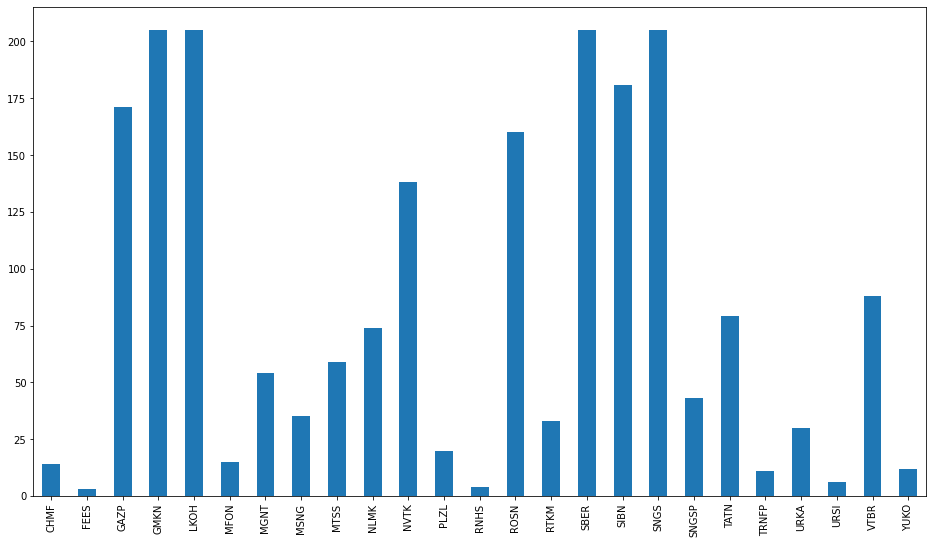

In [26]:
picks = top10_portfolio.picks
at_least_1_pick = (picks.sum() > 0)
picks[picks.columns[at_least_1_pick]].sum().plot.bar()

По графику прибыльных периодов видно, что вероятность прибыльного периода колеблется около 50%, но чаще все-таки выше.

<AxesSubplot:xlabel='Date'>

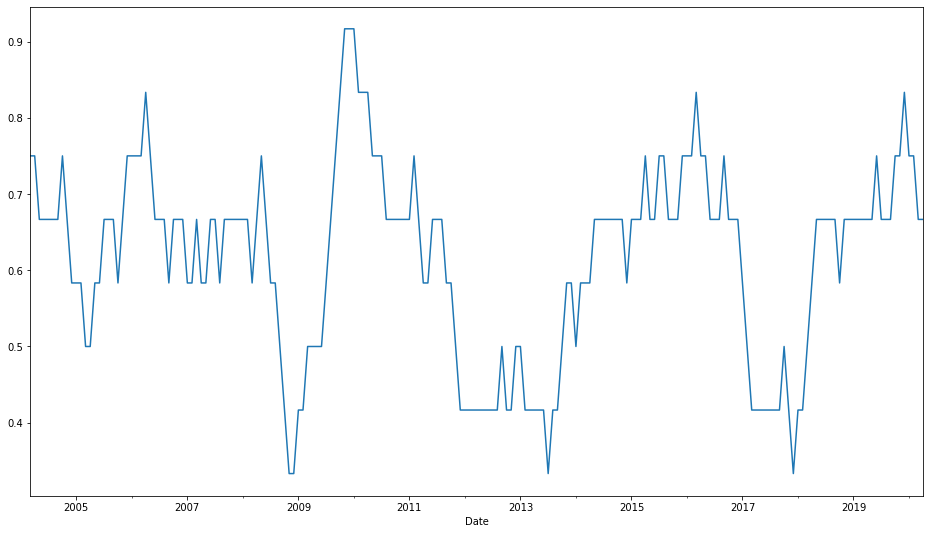

In [27]:
pqr.rolling_win_rate(top10_portfolio.returns).plot()

Также видно, что действительно портфель не обгоняет бенчмарк почти никогда.

<AxesSubplot:xlabel='Date'>

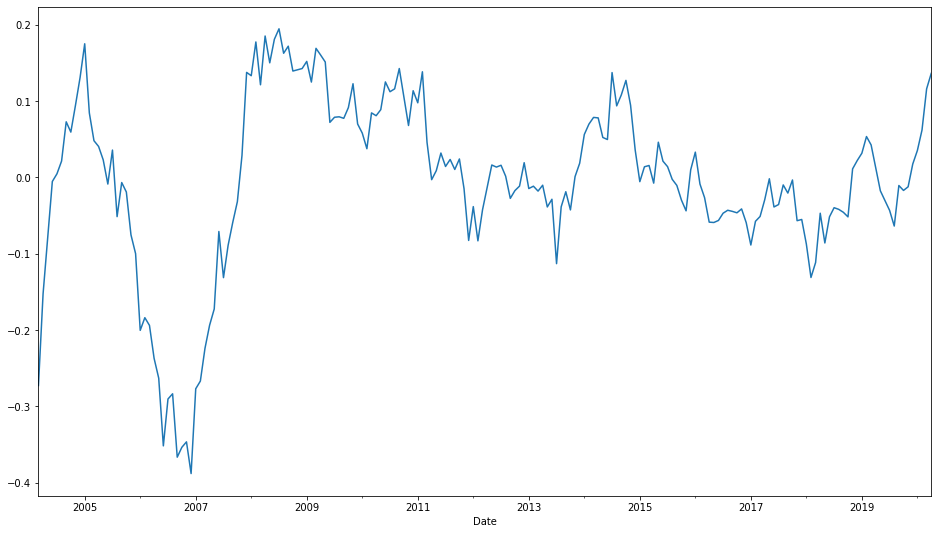

In [28]:
pqr.rolling_mean_excess_return(top10_portfolio.returns, benchmark.returns).plot()

# Случайный тест

Суть теста заключается в том, что мы строим много (для примера 1000) случайных портфелей. Случайный портфели строятся так:
* сначала считаем, сколько акций мы купили в каждый период времени
* затем выбираем то же количество акций случайным образом для каждого периода
* повторяем это 1000 раз

Затем вспоминаем, что тестируем мы по таргету - метрике, которую мы хотим проанализировать для нашего портфеля. Считаем метрику у всех 1000 случайных портфелей, получилось распределение случайной величины - метрики. Берем несколько (для примера 5) квантилей этой случайной величины, и отбираем только те портфели, которые являются пограничными для каждого квантиля по этой метрике. На выходе получаем столбец из значений метрики-таргета и массив портфелей, соответствующих значениям. Можем отрисовать их кумулятивные доходности, например.

Есть одна проблема: таргет - это любая функция, которая на вход принимает портфель, и возвращает число. Благодаря этому вы можете написать свою метрику и запросто провести тест на ее основе. Однако минус данного подхода в том, что нельзя напрямую запихнуть метрики, для расчета которых необходим бенчмарк.

In [29]:
import functools as ft

# но в этом нам поможет встроенный в python модуль functools
# в нем есть функция partial, которая принимает на вход функцию и аргументы, которые необходимо зафиксировать
# зафиксируем бенчмарк для расчета альфы, и готово
target_alpha = lambda r: pqr.alpha(r, benchmark.returns).value

In [30]:
%%time
%%capture

random_portfolios = pqr.zero_intelligence_test(
    prices, top10_portfolio, target_alpha, quantiles=5,
    n=1000, mask=liquidity_filter
)

CPU times: user 20.7 s, sys: 728 ms, total: 21.4 s
Wall time: 21.4 s


In [31]:
random_portfolios

{-0.0339342691742851: Portfolio('random'),
 -0.009124844973364687: Portfolio('random'),
 -0.0016603584070811026: Portfolio('random'),
 0.008712324036178961: Portfolio('random'),
 0.06582125951380499: Portfolio('random')}

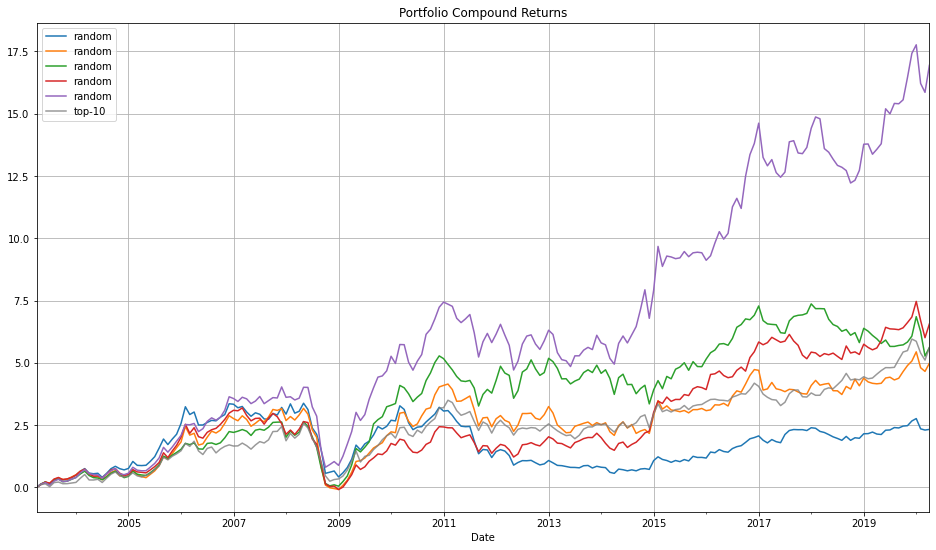

In [32]:
pqr.plot_compound_returns(random_portfolios.values(), benchmark=top10_portfolio)